In [2]:
%matplotlib inline
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import pandas as pd
import cv2, os
import numpy as np
import random as rd
from tqdm.auto import tqdm
import visualkeras as vk
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-08-06 18:11:51.503095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 18:11:51.506609: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 18:11:51.506708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
allImgs = './train_val/'
trainMap = pd.read_csv('train.csv')
valMap = pd.read_csv('val.csv')
ext='.png'
trainImgs=[]
trainLabels=[]
valImgs=[]
valLabels=[]

for i in range(len(trainMap['imgIndex'])):
#     trainImgs.append(cv2.cvtColor(cv2.imread(allImgs+str(trainMap['imgIndex'][i])+ext),cv2.COLOR_BGR2GRAY))
    trainImgs.append(cv2.cvtColor(cv2.imread(allImgs+str(trainMap['imgIndex'][i])+ext),cv2.COLOR_BGR2RGB))
trainImgs = np.array(trainImgs)

trainLabels = np.array(trainMap['label'])
trainImgs=np.array(trainImgs).astype('float32')/255.0

for i in range(len(valMap['imgIndex'])):
#     valImgs.append(cv2.cvtColor(cv2.imread(allImgs+str(valMap['imgIndex'][i])+ext), cv2.COLOR_BGR2GRAY))
    valImgs.append(cv2.cvtColor(cv2.imread(allImgs+str(valMap['imgIndex'][i])+ext), cv2.COLOR_BGR2RGB))
valImgs=np.array(valImgs).astype('float32')/255.0
valLabels=np.array(valMap['label'])
# classes = list(set(valLabels))
# clsDict={}
# for i in range(len(classes)):
#     clsDict[classes[i]]=i
clsDict={'vbar_categorical': 0, 'hbar_categorical': 1, 'dot_line': 2, 'pie': 3, 'line': 4}
print(clsDict)
keyz=list(clsDict.keys()) 

trainLabels=np.array(list(map(lambda x: clsDict[x], trainLabels)))
trainLabels=np.array(keras.utils.to_categorical(trainLabels))
valLabels=np.array(list(map(lambda x: clsDict[x], valLabels)))
valLabels=np.array(keras.utils.to_categorical(valLabels))
print(valLabels[:6])

{'vbar_categorical': 0, 'hbar_categorical': 1, 'dot_line': 2, 'pie': 3, 'line': 4}
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


/home/plant/Envs/anand/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


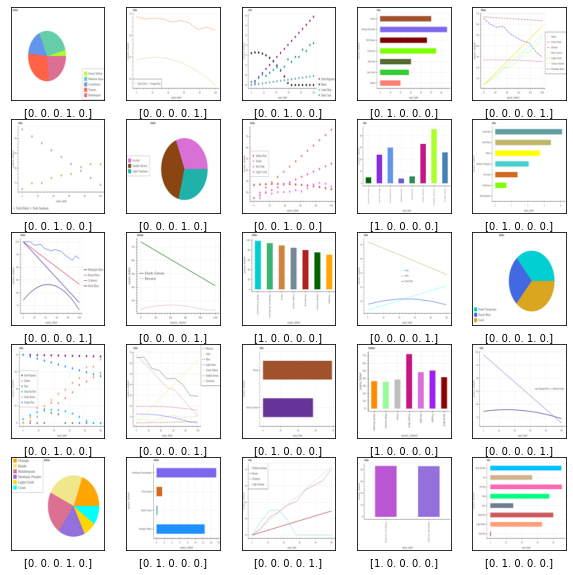

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    randIndex = rd.randrange(0, 850)
    plt.imshow(trainImgs[randIndex],cmap='Greys_r')
    plt.xlabel(trainLabels[randIndex])
plt.show()

## Models:            Size in MB

* VGG16              : 528
* ResNet101-V2       : 171
* EfficientNet-V2-B3 : 59
* MobileNet-V2       : 14

## VGG16

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 4s 114ms/step - loss: 2.9587 - accuracy: 0.1835 - val_loss: 1.6037 - val_accuracy: 0.2000
Epoch 2/100
27/27 [==============================] - 3s 106ms/step - loss: 1.5920 - accuracy: 0.2424 - val_loss: 1.6084 - val_accuracy: 0.3467
Epoch 3/100
27/27 [=

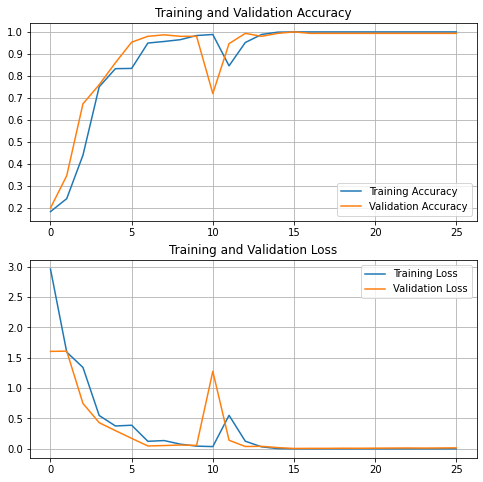

1/1 [==============================] - 0s 87ms/step
hbar_categorical


In [13]:
modelVGG16 = keras.models.Sequential()
modelVGG16.add(keras.applications.VGG16(include_top=False, input_shape=(128,128, 3), pooling='max'))
modelVGG16.add(keras.layers.Flatten())
modelVGG16.add(keras.layers.Dense(5, activation='softmax'))

modelVGG16.summary()

modelVGG16.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights= True, patience=10, verbose=1)
callback = [early_stop]

history = modelVGG16.fit(trainImgs, trainLabels, epochs=100, 
                    validation_data=(valImgs, valLabels), callbacks=callback)

for i in history.history.keys():
    print(i+' '*(12-len(i)) +': '+ str(history.history[i][-1]))
    
epochs=history.epoch[-1]+1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

testImg = keras.utils.load_img('./test/1.png', target_size=(128,128), color_mode='rgb')
img_array = tf.keras.utils.img_to_array(testImg)
img_array = tf.expand_dims(img_array, 0)
predictions = modelVGG16.predict(img_array)
keyz=list(clsDict.keys()) 
print(keyz[list(predictions[0]).index(1)])



In [4]:
for i in history.history.keys():
    print(i+' '*(12-len(i)) +': '+ str(history.history[i][-1]))

loss        : 3.0783942861489777e-07
accuracy    : 1.0
val_loss    : 0.00012572549167089164
val_accuracy: 1.0


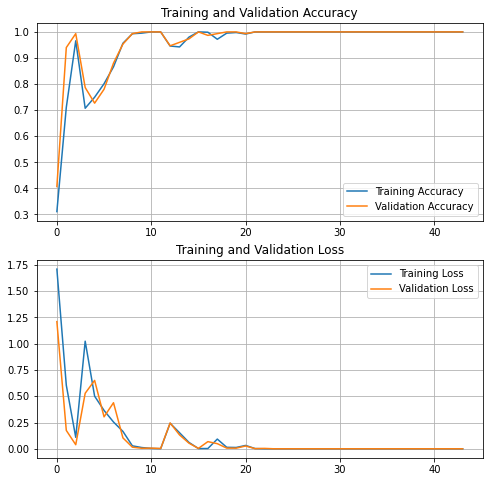

  0%|          | 0/50 [00:00<?, ?it/s]

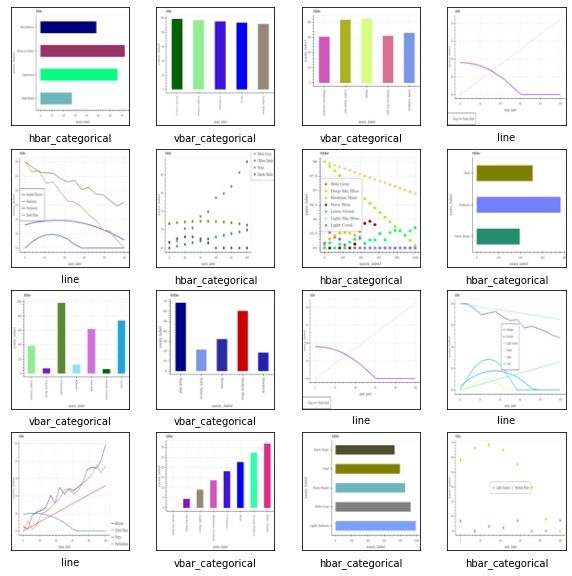

In [5]:
epochs=history.epoch[-1]+1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

keyz=list(clsDict.keys()) 
preds={}
for i in tqdm(range(0, 50)):
    testImg = keras.utils.load_img('./test/{}.png'.format(i), target_size=(128,128),color_mode='rgb')
    img_array = tf.keras.utils.img_to_array(testImg)
    img_array = tf.expand_dims(img_array, 0)
    predictions = modelVGG16.predict(img_array, verbose=0)
    pred=keyz[list(predictions[0]).index(1)]
    preds[i]=pred

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    randIndex = rd.choice(list(preds.keys()))
    plt.imshow(cv2.imread('./test/{}.png'.format(randIndex)))
    plt.xlabel(preds[randIndex])
plt.show()

In [9]:
testImg = keras.utils.load_img('./test/10.png', target_size=(128,128), color_mode='rgb')
img_array = tf.keras.utils.img_to_array(testImg)
img_array = tf.expand_dims(img_array, 0)
predictions = modelVGG16.predict(img_array)
keyz=list(clsDict.keys()) 
print(keyz)
print(keyz[list(predictions[0]).index(1)])

1/1 [==============================] - 0s 15ms/step
['vbar_categorical', 'hbar_categorical', 'dot_line', 'pie', 'line']
hbar_categorical


2022-08-06 18:12:08.777322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-06 18:12:08.778489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 18:12:08.778677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 18:12:08.778804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

  0%|          | 0/50 [00:00<?, ?it/s]

2022-08-06 18:12:12.349507: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2022-08-06 18:12:13.677233: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


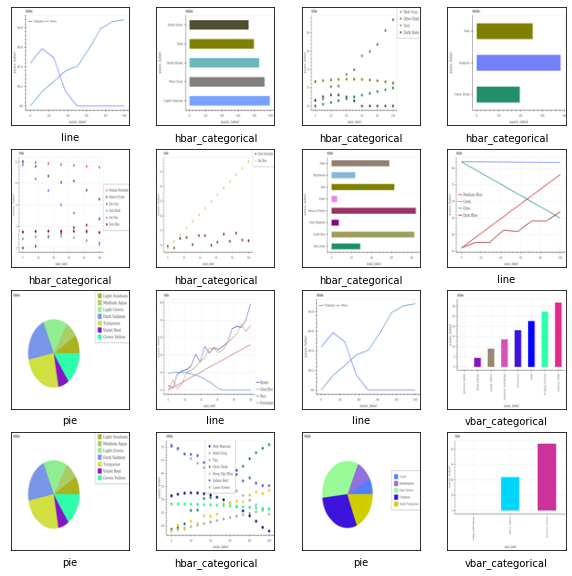

In [5]:
modelVGG16=keras.models.load_model('VGG16Model')
keyz=list(clsDict.keys()) 
preds={}
for i in tqdm(range(0, 50)):
    testImg = keras.utils.load_img('./test/{}.png'.format(i), target_size=(128,128),color_mode='rgb')
    img_array = tf.keras.utils.img_to_array(testImg)
    img_array = tf.expand_dims(img_array, 0)
    predictions = modelVGG16.predict(img_array, verbose=0)
    pred=keyz[list(predictions[0]).index(1)]
    preds[i]=pred

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    randIndex = rd.choice(list(preds.keys()))
    plt.imshow(cv2.imread('./test/{}.png'.format(randIndex)))
    plt.xlabel(preds[randIndex])
plt.show()

In [8]:
modelVGG16.save('./VGG16Model')

INFO:tensorflow:Assets written to: ./VGG16Model/assets


INFO:tensorflow:Assets written to: ./VGG16Model/assets


In [6]:
x=open('vgg16Preds.csv', 'w+')
data='imgLabel,pred\n'
for i in preds.keys():
    data+=str(i)+','+preds[i]+'\n'
x.write(data)
x.close()

## ResNet101V2

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 42,636,805
Trainable params: 42,539,141
Non-trainable params: 97,664
_________________________________________________________________


/home/plant/Envs/anand/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


/home/plant/Envs/anand/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


27/27 [==============================] - 11s 186ms/step - loss: 0.4368 - accuracy: 0.9059 - val_loss: 1.0455 - val_accuracy: 0.8333
Epoch 2/100
27/27 [==============================] - 4s 144ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.5455 - val_accuracy: 0.8600
Epoch 3/100
27/27 [==============================] - 4s 146ms/step - loss: 0.0108 - accuracy: 0.9953 - val_loss: 0.2661 - val_accuracy: 0.9533
Epoch 4/100
27/27 [==============================] - 4s 146ms/step - loss: 0.0058 - accuracy: 0.9988 - val_loss: 0.0816 - val_accuracy: 0.9800
Epoch 5/100
27/27 [==============================] - 4s 145ms/step - loss: 0.0151 - accuracy: 0.9976 - val_loss: 0.0475 - val_accuracy: 0.9867
Epoch 6/100
27/27 [==============================] - 4s 146ms/step - loss: 0.0386 - accuracy: 0.9929 - val_loss: 0.0143 - val_accuracy: 0.9933
Epoch 7/100
27/27 [==============================] - 4s 141ms/step - loss: 0.0333 - accuracy: 0.9918 - val_loss: 0.0471 - val_accuracy: 0.9800
Epoch 8/10

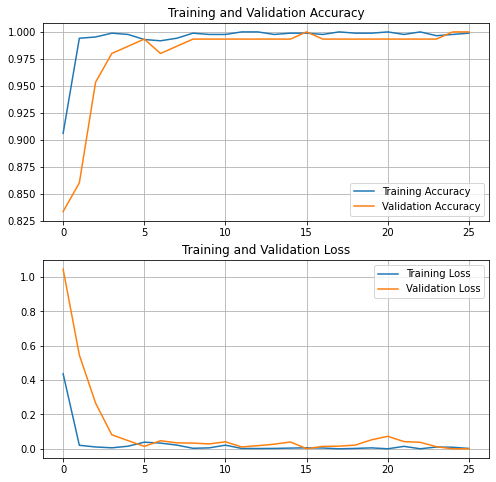

  0%|          | 0/50 [00:00<?, ?it/s]

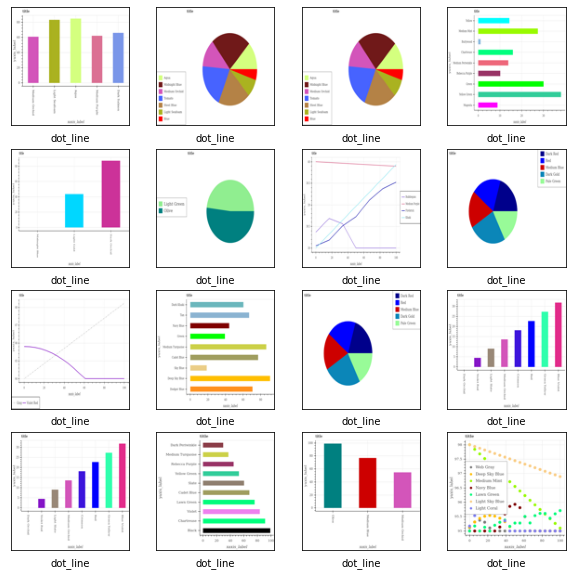

INFO:tensorflow:Assets written to: ./ResNet101V2Model/assets


INFO:tensorflow:Assets written to: ./ResNet101V2Model/assets


In [15]:
modelres = keras.models.Sequential()
resnetLayer=keras.applications.ResNet101V2(include_top=False, input_shape=(128,128, 3), pooling='max')
resnetLayer.layers[0].trainable=False
# resnetLayer.layers[1].trainable=False
modelres.add(resnetLayer)
modelres.add(keras.layers.Flatten())
modelres.add(keras.layers.Dense(5, activation='softmax'))

modelres.summary()
optimizer = keras.optimizers.Adam(lr=0.0001)

modelres.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stop=keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights= True, patience=10, verbose=1)
callback = [early_stop]

history = modelres.fit(trainImgs, trainLabels, epochs=100, 
                    validation_data=(valImgs, valLabels), callbacks=callback)

for i in history.history.keys():
    print(i+' '*(12-len(i)) +': '+ str(history.history[i][-1]))
    
epochs=history.epoch[-1]+1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# keyz=list(clsDict.keys()) 
preds={}
for i in tqdm(range(0, 50)):
    testImg = keras.utils.load_img('./test/{}.png'.format(i), target_size=(128,128),color_mode='rgb')
    img_array = tf.keras.utils.img_to_array(testImg)
    img_array = tf.expand_dims(img_array, 0)
    predictions = modelres.predict(img_array, verbose=0)
    pred=keyz[list(predictions[0]).index(1)]
    preds[i]=pred

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    randIndex = rd.choice(list(preds.keys()))
    plt.imshow(cv2.imread('./test/{}.png'.format(randIndex)))
    plt.xlabel(preds[randIndex])
plt.show()

modelres.save('./ResNet101V2Model')
x=open('resPreds.csv', 'w+')
data='imgLabel,pred\n'
for i in preds.keys():
    data+=str(i)+','+preds[i]+'\n'
x.write(data)
x.close()

loss        : 0.01547339279204607
accuracy    : 0.9952940940856934
val_loss    : 0.00034343323204666376
val_accuracy: 1.0


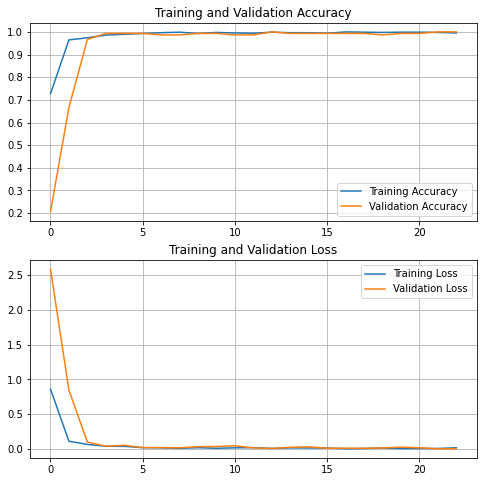

  0%|          | 0/50 [00:00<?, ?it/s]

1 is not in list
[[9.9275547e-01 3.6541993e-12 0.0000000e+00 0.0000000e+00 7.2444966e-03]]


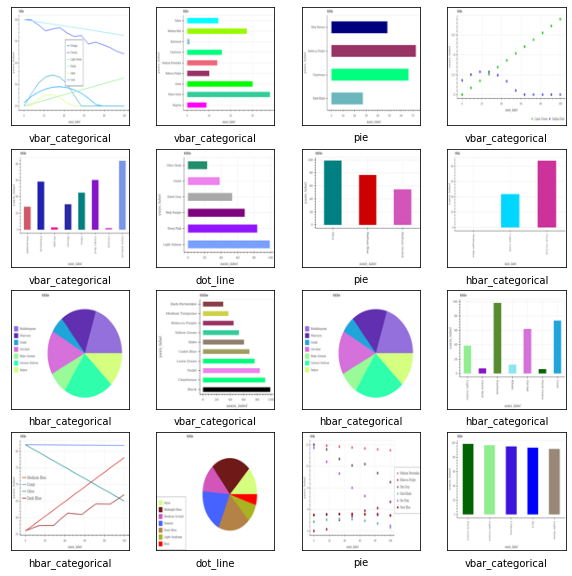

INFO:tensorflow:Assets written to: ./ResNet101V2Model/assets


INFO:tensorflow:Assets written to: ./ResNet101V2Model/assets


In [17]:
# modeleff = keras.models.Sequential()
# effLayer=keras.applications.EfficientNetV2B3(include_top=False, input_shape=(128,128, 3), pooling='max')
# effLayer.layers[0].trainable=False
# # resnetLayer.layers[1].trainable=False
# modeleff.add(effLayer)
# modeleff.add(keras.layers.Flatten())
# modeleff.add(keras.layers.Dense(5, activation='softmax'))

# modeleff.summary()
# optimizer = keras.optimizers.Adam(lr=0.0001)

# modeleff.compile(optimizer=optimizer,
#               loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# early_stop=keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights= True, patience=10, verbose=1)
# callback = [early_stop]

# history = modeleff.fit(trainImgs, trainLabels, epochs=100, 
#                     validation_data=(valImgs, valLabels), callbacks=callback)

for i in history.history.keys():
    print(i+' '*(12-len(i)) +': '+ str(history.history[i][-1]))
    
epochs=history.epoch[-1]+1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# keyz=list(clsDict.keys()) 
preds={}
for i in tqdm(range(0, 50)):
    testImg = keras.utils.load_img('./test/{}.png'.format(i), target_size=(128,128),color_mode='rgb')
    img_array = tf.keras.utils.img_to_array(testImg)
    img_array = tf.expand_dims(img_array, 0)
    predictions = modeleff.predict(img_array, verbose=0)
    try:
        pred=keyz[list(predictions[0]).index(1)]
    except Exception as e:
        print(e)
        print(predictions)
    preds[i]=pred

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    randIndex = rd.choice(list(preds.keys()))
    plt.imshow(cv2.imread('./test/{}.png'.format(randIndex)))
    plt.xlabel(preds[randIndex])
plt.show()

modeleff.save('./ResNet101V2Model')
x=open('resPreds.csv', 'w+')
data='imgLabel,pred\n'
for i in preds.keys():
    data+=str(i)+','+preds[i]+'\n'
x.write(data)
x.close()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 flatten_9 (Flatten)         (None, 960)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                 4805      
                                                                 
Total params: 3,001,157
Trainable params: 2,976,757
Non-trainable params: 24,400
_________________________________________________________________
Epoch 1/100


/home/plant/Envs/anand/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


27/27 [==============================] - 7s 116ms/step - loss: 1.5962 - accuracy: 0.7729 - val_loss: 2.1263 - val_accuracy: 0.1267
Epoch 2/100
27/27 [==============================] - 1s 53ms/step - loss: 0.0210 - accuracy: 0.9918 - val_loss: 2.1012 - val_accuracy: 0.1133
Epoch 3/100
27/27 [==============================] - 1s 52ms/step - loss: 0.0262 - accuracy: 0.9894 - val_loss: 2.0880 - val_accuracy: 0.1067
Epoch 4/100
27/27 [==============================] - 1s 53ms/step - loss: 0.0168 - accuracy: 0.9976 - val_loss: 2.0584 - val_accuracy: 0.1400
Epoch 5/100
27/27 [==============================] - 1s 51ms/step - loss: 0.0062 - accuracy: 0.9976 - val_loss: 2.0511 - val_accuracy: 0.1400
Epoch 6/100
27/27 [==============================] - 1s 55ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 2.0415 - val_accuracy: 0.1467
Epoch 7/100
27/27 [==============================] - 1s 53ms/step - loss: 5.0472e-04 - accuracy: 1.0000 - val_loss: 2.0194 - val_accuracy: 0.1467
Epoch 8/100
2

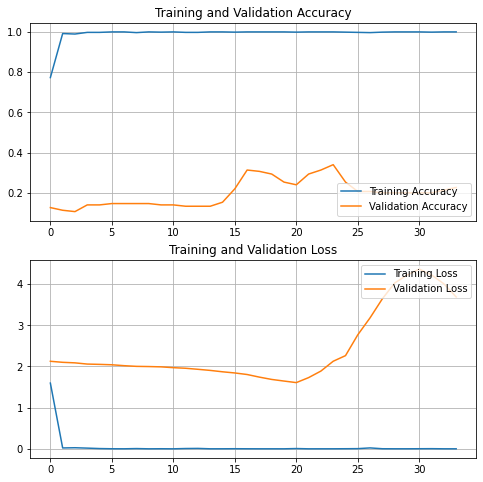

  0%|          | 0/50 [00:00<?, ?it/s]

ValueError: 1 is not in list

In [19]:
modelmob = keras.models.Sequential()
mobLayer=keras.applications.MobileNetV3Large(include_top=False, input_shape=(128,128, 3), pooling='max')
# resnetLayer.layers[0].trainable=False
# resnetLayer.layers[1].trainable=False
modelmob.add(mobLayer)
modelmob.add(keras.layers.Flatten())
modelmob.add(keras.layers.Dense(5, activation='softmax'))

modelmob.summary()
optimizer = keras.optimizers.Adam(lr=0.0001)

modelmob.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
early_stop=keras.callbacks.EarlyStopping(monitor='val_accuracy', restore_best_weights= True, patience=10, verbose=1)
callback = [early_stop]

history = modelmob.fit(trainImgs, trainLabels, epochs=100, 
                    validation_data=(valImgs, valLabels), callbacks=callback)

for i in history.history.keys():
    print(i+' '*(12-len(i)) +': '+ str(history.history[i][-1]))
    
epochs=history.epoch[-1]+1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# keyz=list(clsDict.keys()) 
preds={}
for i in tqdm(range(0, 50)):
    testImg = keras.utils.load_img('./test/{}.png'.format(i), target_size=(128,128),color_mode='rgb')
    img_array = tf.keras.utils.img_to_array(testImg)
    img_array = tf.expand_dims(img_array, 0)
    predictions = modelmob.predict(img_array, verbose=0)
    pred=keyz[list(predictions[0]).index(1)]
    preds[i]=pred

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    randIndex = rd.choice(list(preds.keys()))
    plt.imshow(cv2.imread('./test/{}.png'.format(randIndex)))
    plt.xlabel(preds[randIndex])
plt.show()

modelmob.save('./MobileNetV3Model')
x=open('resPreds.csv', 'w+')
data='imgLabel,pred\n'
for i in preds.keys():
    data+=str(i)+','+preds[i]+'\n'
x.write(data)
x.close()